**Master IASD**

**Deep Learning for Image Analisis**

**Practical Session Oct 3-2025**
Deadline: Oct 10 / 2025

*The final assessment is graded on a 20-point scale: each question is worth 1 point, except the final question, which is worth 5 points.*

Santiago VELASCO-FORERO
santiago.velasco@minesparis.psl.eu

Teaching assistant:

Camille ROBIN (camille.robin@minesparis.psl.eu)

Pierre ONGHENA (pierre.onghena@minesparis.psl.eu)



In this notebook, we aim to examine the impact of the learning rate and certain architectural choices on the training process of a CNN. It should be noted that drawing general conclusions is difficult, as the experiments are influenced by factors such as random batch selection, random initialization of learnable parameters, and other sources of variability.

This notebook was built with PyTorch. If you’re new to PyTorch, we recommend going through the tutorial available at https://docs.pytorch.org/tutorials/beginner/basics/intro.html

Another references:

https://d2l.ai/

In [1]:
!pip install torchinfo
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from sklearn.metrics import classification_report

print(torch.__version__)  # Prints the PyTorch version

#If you’re using a GPU, you can check availability with:
print('If GPU available', torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


NEPOCHS=48

2.8.0+cu126
If GPU available True


100%|██████████| 26.4M/26.4M [00:02<00:00, 9.20MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 177kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.31MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.28MB/s]


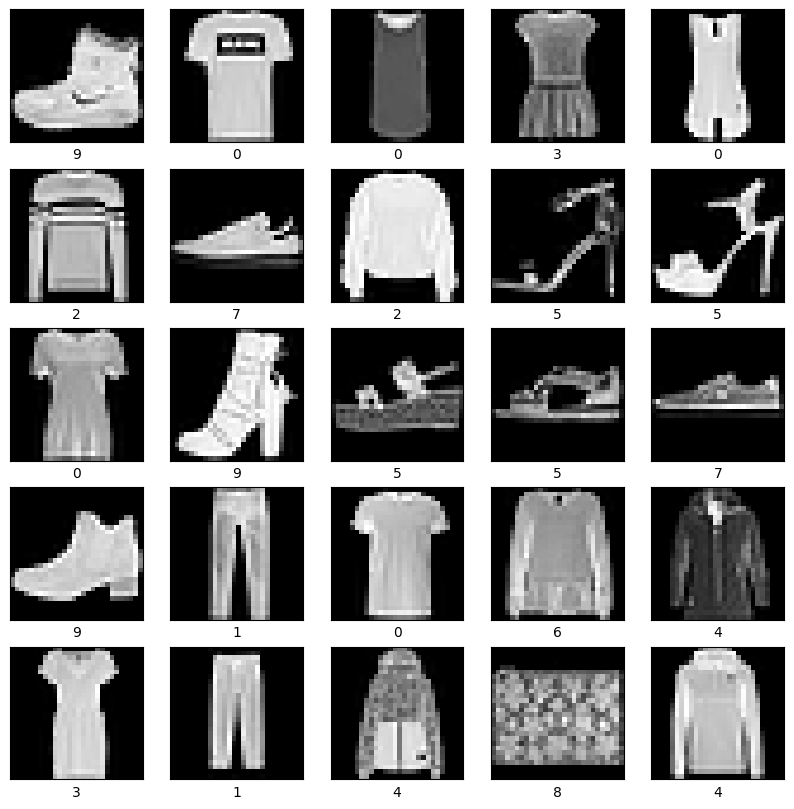

(28, 28)


In [2]:
#Define transforms for training and test data
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5)  # 50% chance of flipping
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])

# Load Fashion-MNIST dataset

train_data = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=train_transform  # Use augmented transform for training
)
test_data = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=test_transform  # No augmentation for test data
)

# Convert to numpy arrays for visualization (PyTorch tensors are similar to numpy arrays)
train_images = train_data.data.numpy()
train_labels = train_data.targets.numpy()
test_images = test_data.data.numpy()
test_labels = test_data.targets.numpy()

# Normalize images (same as in Keras)
train_images = train_images / 255.0
test_images = test_images / 255.0

# Visualize some examples
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

print(train_images[i].shape)

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class FashionMNISTModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        """
        Initialize the FashionMNIST CNN model.

        Args:
            input_shape (tuple): Shape of input images as (channels, height, width).
            num_classes (int): Number of output classes (10 for Fashion-MNIST).
        """
        # Call the parent class (nn.Module) constructor
        super(FashionMNISTModel, self).__init__()

        # --- Convolutional Layers ---
        # Conv1: Input channels = input_shape[0], Output channels = 16, Kernel = 3x3, Stride = 1, Padding = 1
        # Padding=1 ensures spatial dimensions are preserved (output size = input size)
        self.conv1 = nn.Conv2d(input_shape[0], 16, kernel_size=3, stride=1, padding=1)

        # Conv2: Input channels = 16, Output channels = 32, Kernel = 3x3, Stride = 1, Padding = 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        # MaxPool: Reduces spatial dimensions by half (kernel=2, stride=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv3: Input channels = 32, Output channels = 64, Kernel = 3x3, Stride = 1, Padding = 1
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Conv4: Input channels = 64, Output channels = 96, Kernel = 3x3, Stride = 1, Padding = 1
        self.conv4 = nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1)

        # Global Average Pooling: Reduces each feature map to a single value (output size = 1x1)
        self.globalpool = nn.AdaptiveAvgPool2d(1)

        # Fully Connected Layer: Input features = 96 (from conv4), Output features = num_classes
        self.dense = nn.Linear(96, num_classes)

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Output logits of shape (batch_size, num_classes).
        """
        # Apply Conv1 + ReLU activation
        x = F.relu(self.conv1(x))

        # Apply Conv2 + ReLU activation
        x = F.relu(self.conv2(x))

        # Apply MaxPooling to reduce spatial dimensions
        x = self.pool(x)

        # Apply Conv3 + ReLU activation
        x = F.relu(self.conv3(x))

        # Apply Conv4 + ReLU activation
        x = F.relu(self.conv4(x))

        # Apply Global Average Pooling to get a 1x1 feature map per channel
        x = self.globalpool(x)

        # Flatten the output for the fully connected layer
        # x.size(0) = batch size, -1 = flatten all other dimensions
        x = x.view(x.size(0), -1)

        # Apply the fully connected layer to get class logits
        x = self.dense(x)

        return x


In [4]:
model0=FashionMNISTModel((1,28,28),10)
print(model0)

FashionMNISTModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (globalpool): AdaptiveAvgPool2d(output_size=1)
  (dense): Linear(in_features=96, out_features=10, bias=True)
)


In [5]:
def print_layer_parameters(model):
    """
    Prints the number of parameters for each layer in the model.
    Args:
        model (nn.Module): PyTorch model whose parameters are to be printed.
    """
    for name, param in model.named_parameters():
        # Only consider parameters that require gradients (trainable parameters)
        if param.requires_grad:
            # name: Name of the parameter (e.g., 'conv1.weight')
            # param.numel(): Number of elements in the parameter tensor
            print(f"Layer: {name} | Parameters: {param.numel()}")



In [6]:
def print_layer_parameters_summary(model):
    """
    Prints the total number of parameters for each layer (grouping weights and biases).
    Args:
        model (nn.Module): PyTorch model whose parameters are to be summarized.
    """
    for name, module in model.named_children():
        # Sum the number of elements in all parameters of the current module
        # (both weights and biases, if they exist)
        params = sum(p.numel() for p in module.parameters() if p.requires_grad)
        # Print the layer name and total parameters
        print(f"Layer: {name} | Total Parameters: {params}")

def print_total_trainable_parameters(model):
    """
    Prints the total number of parameters of the model.
    Args:
        model (nn.Module): PyTorch model whose parameters are to be summarized.
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total_params}")
    return total_params

### Code Explanation

**model.named_parameters():**
Iterates over all parameters, returning both the name (e.g., 'conv1.weight') and the parameter tensor.

**param.requires_grad:**
Ensures only trainable parameters are counted (excludes frozen layers).

**param.numel():**
Returns the total number of elements in the parameter tensor (e.g., weights or biases).

**model.named_children():**
Iterates over immediate child modules (layers) of the model, useful for grouping weights and biases of a layer together.

**sum(p.numel() for p in module.parameters() if p.requires_grad):**
Sums the number of elements in all parameters of a layer (both weights and biases).

**total_params:**
Sums all trainable parameters in the model, giving the total model size.

In [7]:
# Example usage:
print_total_trainable_parameters(model0)

Total trainable parameters: 79658


79658

In [8]:
print_layer_parameters(model0)

Layer: conv1.weight | Parameters: 144
Layer: conv1.bias | Parameters: 16
Layer: conv2.weight | Parameters: 4608
Layer: conv2.bias | Parameters: 32
Layer: conv3.weight | Parameters: 18432
Layer: conv3.bias | Parameters: 64
Layer: conv4.weight | Parameters: 55296
Layer: conv4.bias | Parameters: 96
Layer: dense.weight | Parameters: 960
Layer: dense.bias | Parameters: 10


In [9]:
print_layer_parameters_summary(model0)

Layer: conv1 | Total Parameters: 160
Layer: conv2 | Total Parameters: 4640
Layer: pool | Total Parameters: 0
Layer: conv3 | Total Parameters: 18496
Layer: conv4 | Total Parameters: 55392
Layer: globalpool | Total Parameters: 0
Layer: dense | Total Parameters: 970


\**Question 1:** Explain for each layer how the number of parameters is calculated.

*Answer 1:*

It depends on the type of the layer.

In dense (fully connected) layers, all input features are connected to all output features.
The number of weights in such a layer is equal to the number of input neurons multiplied by the number of output neurons.
Each output neuron also has one bias term.

Therefore, the total number of parameters is:
(input_features*output_features) + output features.
For example in the last layer of model0, the input_features = 96 and the output_features = 10. So the number of weights = 960 and the number of biases = 10. So the total number of parameters in this layer is 970.

In a convolutional layer, the calculation is different because the number of weights depends not only on the number of input and output channels, but also on the kernel size.
The total number of weights is: input_channels *output_channels *kernel_height *kernel_width. For exampe for the first convolutional layer of model0 we have:

input_channel = 1, output_channel = 16, kernel_size = 3*3. So the number of weights are equal to 144. And the number of biases are equal to output channels. So the total number of parameters of this CNN layer is 160.

In this calculations we assumed that the bias = True and all weights are trainable.

In batch normalization layers the total parameter is equal to two times the number of features.

There are other types of layers whose parameter counts are computed differently, but since in this exercise the models does not include them, they are not discussed here.

In [10]:
#!pip install torchinfo

In [11]:
import torch.nn as nn
from torchinfo import summary  # For model summary (install with: pip install torchinfo)
summary(model0, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FashionMNISTModel                        [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 28, 28]           160
├─Conv2d: 1-2                            [1, 32, 28, 28]           4,640
├─MaxPool2d: 1-3                         [1, 32, 14, 14]           --
├─Conv2d: 1-4                            [1, 64, 14, 14]           18,496
├─Conv2d: 1-5                            [1, 96, 14, 14]           55,392
├─AdaptiveAvgPool2d: 1-6                 [1, 96, 1, 1]             --
├─Linear: 1-7                            [1, 10]                   970
Total params: 79,658
Trainable params: 79,658
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 18.25
Input size (MB): 0.00
Forward/backward pass size (MB): 0.55
Params size (MB): 0.32
Estimated Total Size (MB): 0.87

In [12]:
def configure_model(
    model: torch.nn.Module,
    optimizer_name: str = "sgd",
    learning_rate: float = 1.0,
    loss_type: str = "cross_entropy",
    **optimizer_kwargs,
) -> tuple[torch.optim.Optimizer, torch.nn.Module]:
    """
    Configures the optimizer and loss function for a PyTorch model.

    Args:
        model: PyTorch model to configure.
        optimizer_name: Name of the optimizer ('sgd', 'adam', 'rmsprop').
        learning_rate: Learning rate for the optimizer.
        loss_type: Type of loss function ('cross_entropy', 'mse', 'bce').
        **optimizer_kwargs: Additional keyword arguments for the optimizer.

    Returns:
        tuple: (optimizer, criterion)

    Example:
        optimizer, criterion = configure_model(
            model, optimizer_name="adam", learning_rate=0.001
        )
    """
    # --- Optimizer ---
    optimizers = {
        "sgd": torch.optim.SGD,
        "adam": torch.optim.Adam,
        "rmsprop": torch.optim.RMSprop,
    }
    if optimizer_name not in optimizers:
        raise ValueError(f"Optimizer {optimizer_name} not supported. Choose from: {list(optimizers.keys())}")
    optimizer = optimizers[optimizer_name](model.parameters(), lr=learning_rate, **optimizer_kwargs)

    # --- Loss Function ---
    if loss_type == "cross_entropy":
        criterion = torch.nn.CrossEntropyLoss()
    elif loss_type == "mse":
        criterion = torch.nn.MSELoss()
    elif loss_type == "bce":
        criterion = torch.nn.BCELoss()
    else:
        raise ValueError(f"Loss {loss_type} not supported. Choose from: 'cross_entropy', 'mse', 'bce'")

    return optimizer, criterion

In [13]:
optimizer, criterion = configure_model(model0,optimizer_name="sgd",learning_rate=1.0,loss_type="cross_entropy")

In [14]:
print(criterion)

CrossEntropyLoss()


In [15]:
def train_model(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    num_epochs: int,
    device: torch.device,
    verbose: bool = True,
    save_path: str = "best_model.pth",
) -> dict:
    """
    Train a PyTorch model and return training/validation metrics.

    Args:
        model: PyTorch model to train.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        optimizer: Optimizer (e.g., SGD, Adam).
        criterion: Loss function (e.g., CrossEntropyLoss).
        num_epochs: Number of training epochs.
        device: Device to train on (CPU/GPU).
        verbose: If True, prints epoch progress.

    Returns:
        history: Dictionary containing training/validation metrics per epoch.
    """
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }

    model = model.to(device)
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        train_loss, train_correct = 0.0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            train_correct += (outputs.argmax(dim=1) == labels).sum().item()

        # --- Validation Phase ---
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()

        # --- Calculate Metrics ---
        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        # --- Store History ---
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)


        # --- Save Best Model ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            if verbose:
                print(f"Validation loss improved to {val_loss:.4f}. Model saved.")

        # --- Print Progress ---
        if verbose:
            print(
                f"Epoch {epoch+1}/{num_epochs}: "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
            )

    # --- Load Best Model ---
    model.load_state_dict(torch.load(save_path))
    if verbose:
        print(f"Best validation loss: {best_val_loss:.4f}. Best model loaded.")

        # --- Print Progress ---
        if verbose:
            print(
                f"Epoch {epoch+1}/{num_epochs}: "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
            )

    return history

In [16]:
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert numpy arrays to PyTorch tensors
train_images_tensor = torch.FloatTensor(train_images).unsqueeze(1)  # Add channel dim: [N, 28, 28] -> [N, 1, 28, 28]
train_labels_tensor = torch.LongTensor(train_labels)  # Use LongTensor for class indices

# Convert test data to tensors (no need to split)
test_images_tensor = torch.FloatTensor(test_images).unsqueeze(1)  # [M, 28, 28] -> [M, 1, 28, 28]
test_labels_tensor = torch.LongTensor(test_labels)

# Create a TensorDataset and split into train/validation
dataset = TensorDataset(train_images_tensor, train_labels_tensor)
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [17]:
# Call the training function
history0 = train_model(
    model=model0,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=NEPOCHS,
    device=device,
)

Validation loss improved to 2.3080. Model saved.
Epoch 1/48: Train Loss: 2.3105, Train Acc: 0.1020, Val Loss: 2.3080, Val Acc: 0.1021
Epoch 2/48: Train Loss: 2.3099, Train Acc: 0.1010, Val Loss: 2.3090, Val Acc: 0.1003
Epoch 3/48: Train Loss: 2.3102, Train Acc: 0.0996, Val Loss: 2.3109, Val Acc: 0.0987
Validation loss improved to 2.3056. Model saved.
Epoch 4/48: Train Loss: 2.3099, Train Acc: 0.1013, Val Loss: 2.3056, Val Acc: 0.0970
Epoch 5/48: Train Loss: 2.3098, Train Acc: 0.0993, Val Loss: 2.3130, Val Acc: 0.1021
Epoch 6/48: Train Loss: 2.3106, Train Acc: 0.1000, Val Loss: 2.3102, Val Acc: 0.0987
Epoch 7/48: Train Loss: 2.3096, Train Acc: 0.1023, Val Loss: 2.3111, Val Acc: 0.0970
Epoch 8/48: Train Loss: 2.3100, Train Acc: 0.0990, Val Loss: 2.3072, Val Acc: 0.1021
Epoch 9/48: Train Loss: 2.3107, Train Acc: 0.0978, Val Loss: 2.3064, Val Acc: 0.0970
Epoch 10/48: Train Loss: 2.3099, Train Acc: 0.1003, Val Loss: 2.3093, Val Acc: 0.0970
Epoch 11/48: Train Loss: 2.3101, Train Acc: 0.0989,

In [18]:
def make_plot_history(history):
    """
    Visualize the training process by plotting accuracy and loss over epochs.

    Args:
        history (dict): Dictionary containing 'train_acc', 'val_acc', 'train_loss', 'val_loss' lists.
    """
    plt.figure(figsize=(10, 8))

    # Accuracy plot
    plt.subplot(2, 1, 1)
    plt.plot(history['train_acc'], label='Training')
    plt.plot(history['val_acc'], label='Validation')
    plt.grid('on')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')

    # Loss plot
    plt.subplot(2, 1, 2)
    plt.plot(history['train_loss'], label='Training')
    plt.plot(history['val_loss'], label='Validation')
    plt.grid('on')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

def make_model_analysis(model, x_test, y_test,device):
    """
    Evaluate a trained PyTorch model and generate a classification report.

    Args:
        model (nn.Module): Trained PyTorch model.
        x_test (torch.Tensor): Test images tensor (shape: [N, 1, 28, 28]).
        y_test (torch.Tensor): True labels tensor.
        device (torch.device): Device where the model is located (CPU/GPU).
    """
    # Set model to evaluation mode
    model.eval()

    # Move test data to the same device as the model
    x_test = x_test.to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(x_test)
        _, y_pred = torch.max(outputs, dim=1)  # Get predicted class indices

    # Move predictions and labels to CPU for numpy conversion
    y_pred = y_pred.cpu().numpy()
    y_test = y_test.numpy()

    print('Predicted Classes', np.unique(y_pred))
    print('Truth Classes', np.unique(y_test))

    # Class names for Fashion MNIST
    target_names = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

    # Generate and print classification report
    print(classification_report(y_test, y_pred, target_names=target_names))

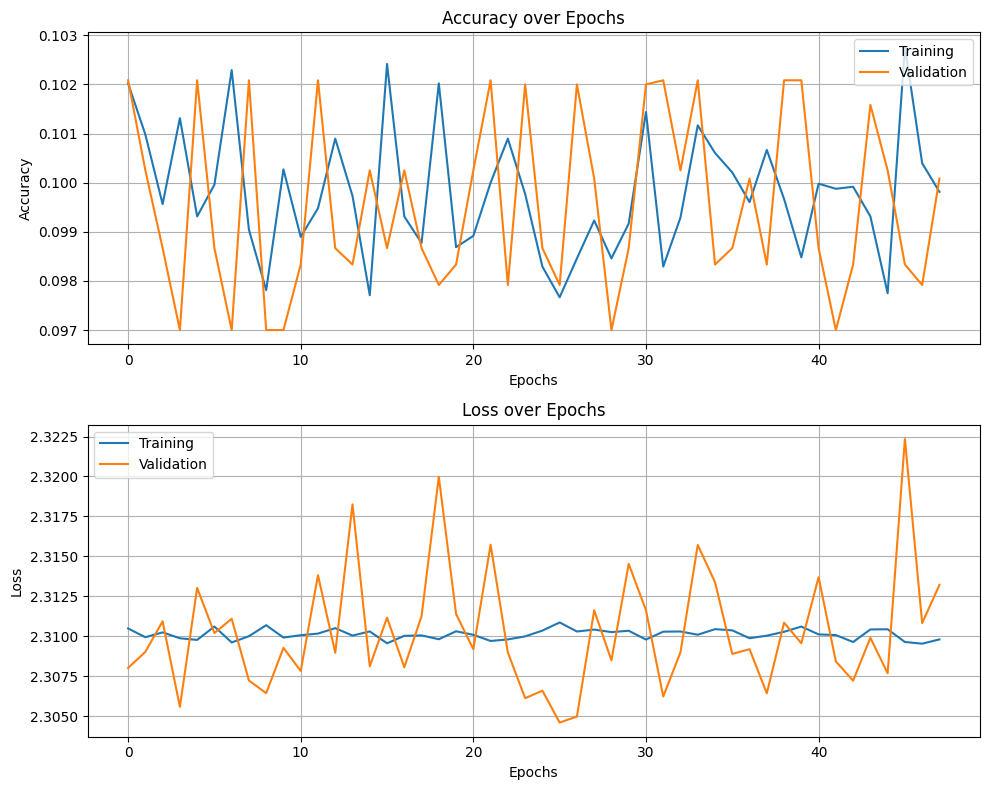

In [19]:
make_plot_history(history0)

In [20]:
make_model_analysis(model0, test_images_tensor, test_labels_tensor,device=device)

Predicted Classes [3]
Truth Classes [0 1 2 3 4 5 6 7 8 9]
              precision    recall  f1-score   support

     T-Shirt       0.00      0.00      0.00      1000
     Trouser       0.00      0.00      0.00      1000
    Pullover       0.00      0.00      0.00      1000
       Dress       0.10      1.00      0.18      1000
        Coat       0.00      0.00      0.00      1000
      Sandal       0.00      0.00      0.00      1000
       Shirt       0.00      0.00      0.00      1000
     Sneaker       0.00      0.00      0.00      1000
         Bag       0.00      0.00      0.00      1000
  Ankle Boot       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Question 2:** Is this model learning well?

*Answer 2:*

No, the model is not learning at all.

The training loss does not decrease over epochs and it stays almost constant, indicating that the model's parameters are not being updated in a meaningful way.
The validation loss also fluctuates randomly, showing no consistent improvement or trend.

Similarly, both training and validation accuracies remain around 10%, which is equivalent to random guessing among 10 classes. The sharp fluctuations in accuracy are just random variations caused by different batches, not signs of learning.

The classification report also confirms this.
Most classes have precision, recall, and F1-scores near zero.
The only class with non-zero recall is predicted for almost every sample, which indicates severe imbalance in model predictions.
The overall accuracy = 0.10, and the macro and weighted averages are extremely low.

**Question 3** Change the learning_rate to a value of 0.001 and train a new model. Call this new model: model1

In [21]:
model1=FashionMNISTModel((1,28,28),10)
optimizer, criterion = configure_model(model1,optimizer_name="sgd",learning_rate=0.001,loss_type="cross_entropy")

In [22]:
# Call the training function
history1 = train_model(
    model=model1,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=NEPOCHS,
    device=device,
)

Validation loss improved to 2.3027. Model saved.
Epoch 1/48: Train Loss: 2.3031, Train Acc: 0.1004, Val Loss: 2.3027, Val Acc: 0.0983
Validation loss improved to 2.3022. Model saved.
Epoch 2/48: Train Loss: 2.3025, Train Acc: 0.1004, Val Loss: 2.3022, Val Acc: 0.0983
Validation loss improved to 2.3017. Model saved.
Epoch 3/48: Train Loss: 2.3019, Train Acc: 0.1004, Val Loss: 2.3017, Val Acc: 0.0983
Validation loss improved to 2.3012. Model saved.
Epoch 4/48: Train Loss: 2.3014, Train Acc: 0.1004, Val Loss: 2.3012, Val Acc: 0.0983
Validation loss improved to 2.3007. Model saved.
Epoch 5/48: Train Loss: 2.3009, Train Acc: 0.1004, Val Loss: 2.3007, Val Acc: 0.0983
Validation loss improved to 2.3000. Model saved.
Epoch 6/48: Train Loss: 2.3003, Train Acc: 0.1004, Val Loss: 2.3000, Val Acc: 0.0984
Validation loss improved to 2.2991. Model saved.
Epoch 7/48: Train Loss: 2.2995, Train Acc: 0.1099, Val Loss: 2.2991, Val Acc: 0.1254
Validation loss improved to 2.2978. Model saved.
Epoch 8/48: T

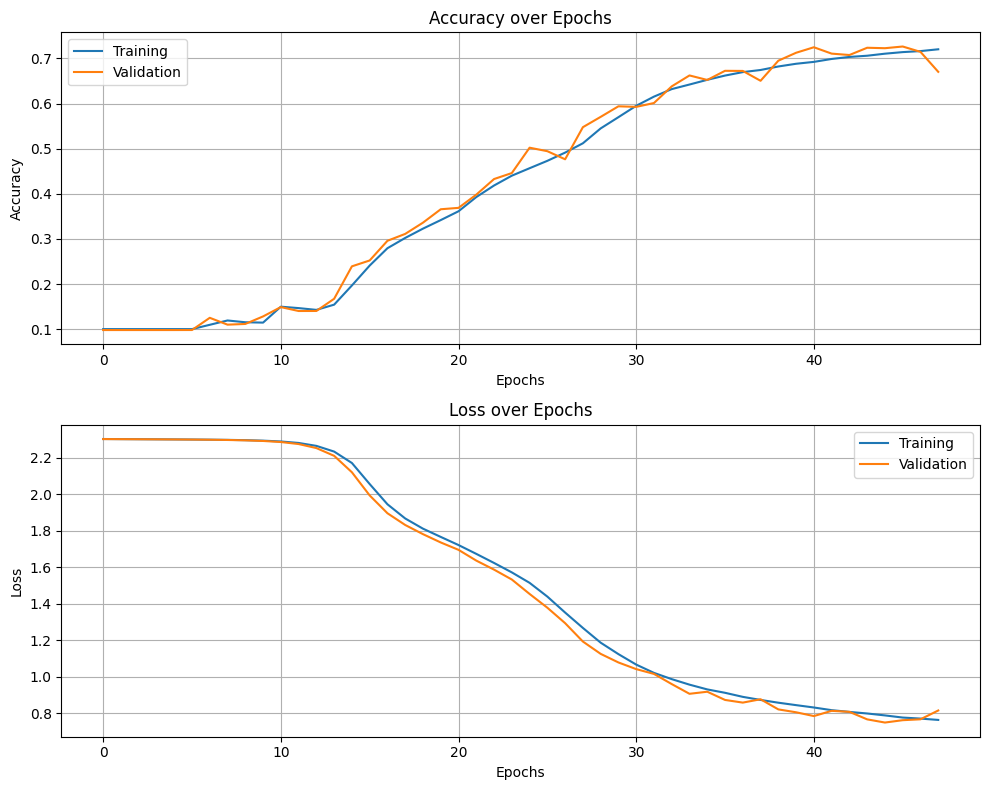

Predicted Classes [0 1 2 3 4 5 6 7 8 9]
Truth Classes [0 1 2 3 4 5 6 7 8 9]
              precision    recall  f1-score   support

     T-Shirt       0.64      0.80      0.71      1000
     Trouser       0.90      0.90      0.90      1000
    Pullover       0.47      0.72      0.57      1000
       Dress       0.67      0.73      0.70      1000
        Coat       0.61      0.49      0.54      1000
      Sandal       0.81      0.84      0.83      1000
       Shirt       0.41      0.10      0.16      1000
     Sneaker       0.85      0.77      0.81      1000
         Bag       0.86      0.93      0.90      1000
  Ankle Boot       0.84      0.90      0.87      1000

    accuracy                           0.72     10000
   macro avg       0.71      0.72      0.70     10000
weighted avg       0.71      0.72      0.70     10000



In [23]:
make_plot_history(history1)
make_model_analysis(model1, test_images_tensor, test_labels_tensor,device=device)

In comparison to model0, the training happened in model1. This is because of choosing a good learning rate. Now that the step size is logical, the model can move to a local minimum and learn effectively.

**Question 4**. Keep the learning_rate 0.001. Change the optimizer from SGD to Adam. Call this model as "model2".

In [24]:
model2=FashionMNISTModel((1,28,28),10)
optimizer, criterion = configure_model(model2,optimizer_name="adam",learning_rate=0.001,loss_type="cross_entropy")

In [25]:
history2 = train_model(
    model=model2,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=NEPOCHS,
    device=device,
)

Validation loss improved to 0.6209. Model saved.
Epoch 1/48: Train Loss: 0.9152, Train Acc: 0.6582, Val Loss: 0.6209, Val Acc: 0.7804
Validation loss improved to 0.4884. Model saved.
Epoch 2/48: Train Loss: 0.5664, Train Acc: 0.7939, Val Loss: 0.4884, Val Acc: 0.8235
Validation loss improved to 0.4879. Model saved.
Epoch 3/48: Train Loss: 0.4789, Train Acc: 0.8274, Val Loss: 0.4879, Val Acc: 0.8227
Validation loss improved to 0.4194. Model saved.
Epoch 4/48: Train Loss: 0.4224, Train Acc: 0.8465, Val Loss: 0.4194, Val Acc: 0.8393
Validation loss improved to 0.3464. Model saved.
Epoch 5/48: Train Loss: 0.3846, Train Acc: 0.8598, Val Loss: 0.3464, Val Acc: 0.8767
Validation loss improved to 0.3275. Model saved.
Epoch 6/48: Train Loss: 0.3566, Train Acc: 0.8704, Val Loss: 0.3275, Val Acc: 0.8858
Epoch 7/48: Train Loss: 0.3337, Train Acc: 0.8794, Val Loss: 0.3318, Val Acc: 0.8803
Validation loss improved to 0.3078. Model saved.
Epoch 8/48: Train Loss: 0.3201, Train Acc: 0.8826, Val Loss: 0

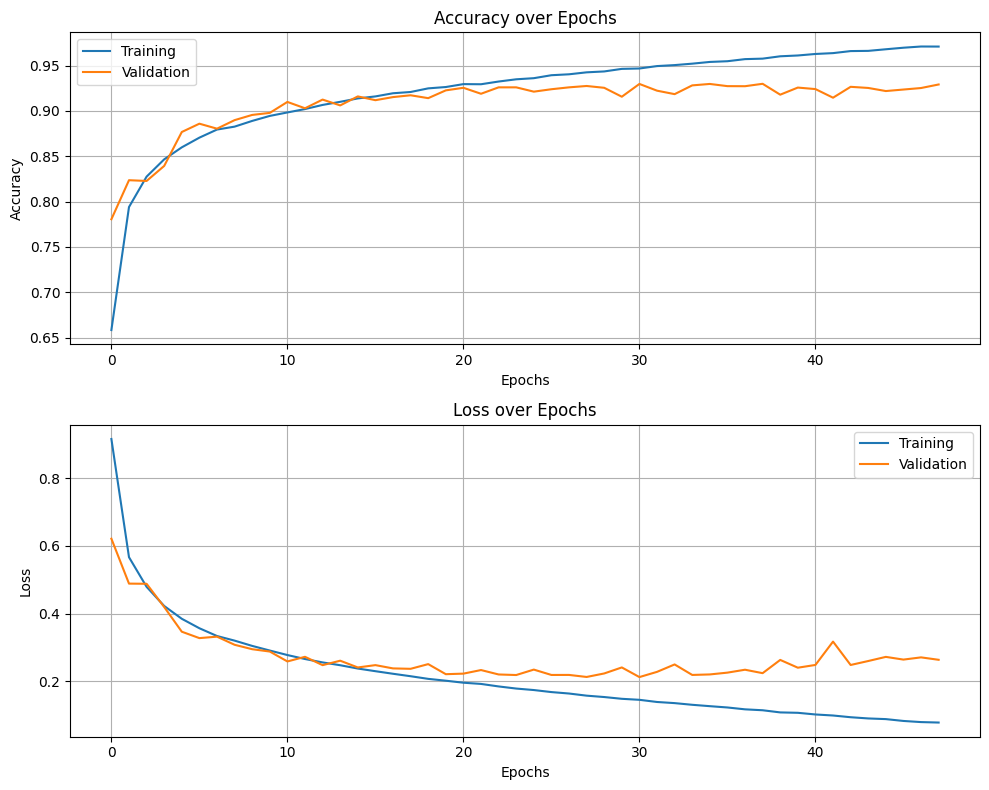

Predicted Classes [0 1 2 3 4 5 6 7 8 9]
Truth Classes [0 1 2 3 4 5 6 7 8 9]
              precision    recall  f1-score   support

     T-Shirt       0.87      0.86      0.86      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.91      0.89      0.90      1000
       Dress       0.92      0.92      0.92      1000
        Coat       0.87      0.90      0.89      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.77      0.77      0.77      1000
     Sneaker       0.94      0.99      0.96      1000
         Bag       0.97      1.00      0.99      1000
  Ankle Boot       0.98      0.95      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [26]:
make_plot_history(history2)
make_model_analysis(model2, test_images_tensor, test_labels_tensor,device=device)

**Question 5**: What is your analysis about the performance of model2?

Answer 5:

First of all, SGD is an optimizer that uses the same learning rate for all parameters. In model1, this means that when the gradients are small, the parameter updates are also very small, which leads to slow learning at the beginning.

In contrast, Adam adapts the learning rate individually for each parameter using estimates of both the first moment (momentum) and the second moment (squared gradients). This allows Adam to make larger and better-scaled updates early in training, helping the model escape flat regions and local minima in the loss surface.

From the plots and the classification report, we can see that model2 learns much more effectively than model1.
The training and validation accuracies increase faster and reach high values.
The loss curves decrease smoothly and remain close together, indicating stable optimization and good generalization.
Model2 shows a small amount of overfitting, but it is small and acceptable given the strong performance.
The classification metrics improved across all classes.

These improvements come from Adam's adaptive learning mechanism, which enables the model to train more effectively.

**Question 6:**

Define a class FashionMNISTModelwithLayerNormalization to create a model as before but adding "LayerNormalization" layer in between each Conv2D and Activation layer. Do not include the bias in the convolution. Call this model as "model3" and check the number of parameter per layer.

https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html



In [27]:
class FashionMNISTModelwithBatchNormalization(nn.Module):
    def __init__(self, input_shape, num_classes):
        """
        Initialize the FashionMNIST CNN model with Batch Normalization.

        Args:
            input_shape (tuple): Shape of input images as (channels, height, width).
            num_classes (int): Number of output classes (10 for Fashion-MNIST).
        """
        super(FashionMNISTModelwithBatchNormalization, self).__init__()


        # --- Convolutional Layers ---
        self.conv1 = nn.Conv2d(input_shape[0], 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm1 = nn.BatchNorm2d(16)

        # Conv2: Input channels = 16, Output channels = 32, Kernel = 3x3, Stride = 1, Padding = 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm2 = nn.BatchNorm2d(32)

        # MaxPool: Reduces spatial dimensions by half (kernel=2, stride=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv3: Input channels = 32, Output channels = 64, Kernel = 3x3, Stride = 1, Padding = 1
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm3 = nn.BatchNorm2d(64)

        # Conv4: Input channels = 64, Output channels = 96, Kernel = 3x3, Stride = 1, Padding = 1
        self.conv4 = nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm4 = nn.BatchNorm2d(96)

        # Global Average Pooling: Reduces each feature map to a single value (output size = 1x1)
        self.globalpool = nn.AdaptiveAvgPool2d(1)

        # Fully Connected Layer: Input features = 96 (from conv4), Output features = num_classes
        self.dense = nn.Linear(96, num_classes)

    def forward(self, x):
        # Conv1 + BatchNorm + ReLU
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)

        # Conv2 + BatchNorm + ReLU
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)

        # MaxPool
        x = self.pool(x)

        # Conv3 + BatchNorm + ReLU
        x = self.conv3(x)
        x = self.norm3(x)
        x = F.relu(x)

        # Conv4 + BatchNorm + ReLU
        x = self.conv4(x)
        x = self.norm4(x)
        x = F.relu(x)

        # Global Average Pooling + Flatten + Dense
        x = self.globalpool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dense(x)

        return x

In [28]:
class FashionMNISTModelwithLayerNormalization(nn.Module):
    def __init__(self, input_shape, num_classes):
        """
        Initialize the FashionMNIST CNN model with Layer Normalization.

        Args:
            input_shape (tuple): Shape of input images as (channels, height, width).
            num_classes (int): Number of output classes (10 for Fashion-MNIST).
        """
        super(FashionMNISTModelwithLayerNormalization, self).__init__()
        C, H, W = input_shape

        # --- Convolutional Layers ---
        self.conv1 = nn.Conv2d(C, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm1 = nn.LayerNorm([16, H, W]) # LayerNorm for Conv1 output shape: [batch, 16, 28, 28]

        # Conv2: Input channels = 16, Output channels = 32, Kernel = 3x3, Stride = 1, Padding = 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm2 = nn.LayerNorm([32, H, W])

        # MaxPool: Reduces spatial dimensions by half (kernel=2, stride=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        H, W = H // 2, W // 2
        # Conv3: Input channels = 32, Output channels = 64, Kernel = 3x3, Stride = 1, Padding = 1
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm3 = nn.LayerNorm([64, H, W])

        # Conv4: Input channels = 64, Output channels = 96, Kernel = 3x3, Stride = 1, Padding = 1
        self.conv4 = nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm4 = nn.LayerNorm([96, H, W])

        # Global Average Pooling: Reduces each feature map to a single value (output size = 1x1)
        self.globalpool = nn.AdaptiveAvgPool2d(1)

        # Fully Connected Layer: Input features = 96 (from conv4), Output features = num_classes
        self.dense = nn.Linear(96, num_classes)

    def forward(self, x):
        # Conv1 + LayerNorm + ReLU
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)

        # Conv2 + LayerNorm + ReLU
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)

        # MaxPool
        x = self.pool(x)

        # Conv3 + LayerNorm + ReLU
        x = self.conv3(x)
        x = self.norm3(x)
        x = F.relu(x)

        # Conv4 + LayerNorm + ReLU
        x = self.conv4(x)
        x = self.norm4(x)
        x = F.relu(x)

        # Global Average Pooling + Flatten + Dense
        x = self.globalpool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dense(x)

        return x

In [29]:
model3=FashionMNISTModelwithLayerNormalization((1,28,28),10)
summary(model3, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FashionMNISTModelwithLayerNormalization  [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 28, 28]           144
├─LayerNorm: 1-2                         [1, 16, 28, 28]           25,088
├─Conv2d: 1-3                            [1, 32, 28, 28]           4,608
├─LayerNorm: 1-4                         [1, 32, 28, 28]           50,176
├─MaxPool2d: 1-5                         [1, 32, 14, 14]           --
├─Conv2d: 1-6                            [1, 64, 14, 14]           18,432
├─LayerNorm: 1-7                         [1, 64, 14, 14]           25,088
├─Conv2d: 1-8                            [1, 96, 14, 14]           55,296
├─LayerNorm: 1-9                         [1, 96, 14, 14]           37,632
├─AdaptiveAvgPool2d: 1-10                [1, 96, 1, 1]             --
├─Linear: 1-11                           [1, 10]                   970
Total params: 217,434
Trainable params: 217,434
Non-trai

In [30]:
optimizer, criterion = configure_model(model3,optimizer_name="adam",learning_rate=0.001,loss_type="cross_entropy")
history3 = train_model(
    model=model3,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=NEPOCHS,
    device=device,
)

Validation loss improved to 0.4185. Model saved.
Epoch 1/48: Train Loss: 0.6831, Train Acc: 0.7477, Val Loss: 0.4185, Val Acc: 0.8470
Validation loss improved to 0.3398. Model saved.
Epoch 2/48: Train Loss: 0.3995, Train Acc: 0.8524, Val Loss: 0.3398, Val Acc: 0.8768
Validation loss improved to 0.3066. Model saved.
Epoch 3/48: Train Loss: 0.3476, Train Acc: 0.8711, Val Loss: 0.3066, Val Acc: 0.8892
Validation loss improved to 0.2927. Model saved.
Epoch 4/48: Train Loss: 0.3091, Train Acc: 0.8855, Val Loss: 0.2927, Val Acc: 0.8972
Validation loss improved to 0.2737. Model saved.
Epoch 5/48: Train Loss: 0.2846, Train Acc: 0.8951, Val Loss: 0.2737, Val Acc: 0.8991
Validation loss improved to 0.2603. Model saved.
Epoch 6/48: Train Loss: 0.2630, Train Acc: 0.9033, Val Loss: 0.2603, Val Acc: 0.9058
Validation loss improved to 0.2504. Model saved.
Epoch 7/48: Train Loss: 0.2477, Train Acc: 0.9079, Val Loss: 0.2504, Val Acc: 0.9117
Validation loss improved to 0.2483. Model saved.
Epoch 8/48: T

Text(0, 0.5, 'Validation Accuracy')

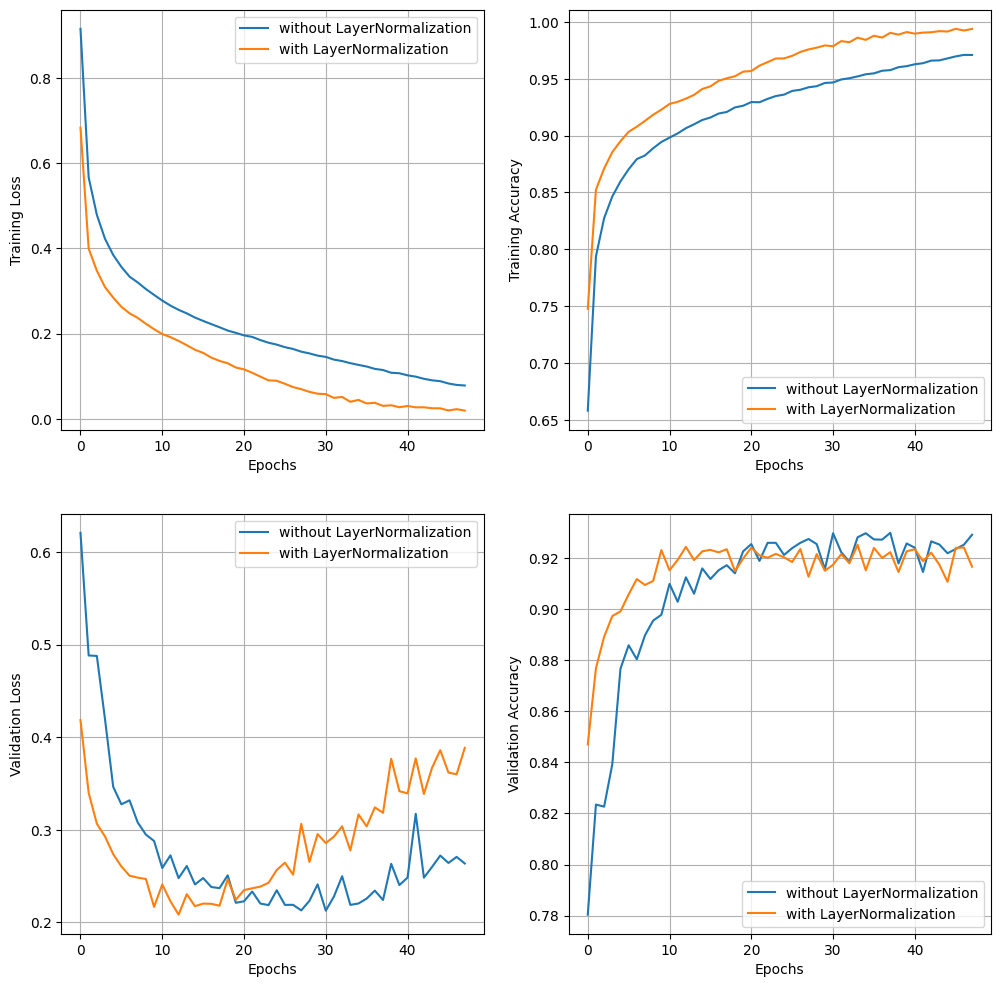

In [31]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.plot(history2['train_loss'],label='without LayerNormalization')
plt.plot(history3['train_loss'],label='with LayerNormalization')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.subplot(2,2,2)
plt.plot(history2['train_acc'],label='without LayerNormalization')
plt.plot(history3['train_acc'],label='with LayerNormalization')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.subplot(2,2,3)
plt.plot(history2['val_loss'],label='without LayerNormalization')
plt.plot(history3['val_loss'],label='with LayerNormalization')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.subplot(2,2,4)
plt.plot(history2['val_acc'],label='without LayerNormalization')
plt.plot(history3['val_acc'],label='with LayerNormalization')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

**Question 7:** What is your analysis about the performance of Model3?

Answer 7:

As we can see, training with Layer Normalization shows faster convergence, and the training loss reaches a lower value than in Model 2. The training accuracy also rises to a higher level because LayerNorm helps stabilize gradients and improves optimization efficiency.

However, the validation behavior is different. The validation loss decreases significantly during the first 20 epochs but then starts to increase, showing that the model fits the training data well but not the validation data which is a clear sign of overfitting. The validation accuracy also slightly drops after a certain point, showing this observation.

LayerNorm stabilizes intermediate activations and gradients, leading to faster and smoother training but because it normalizes across all spatial and channel dimensions, it can remove some local feature variations that are useful for generalization.
As a result, Model 3 learns quickly and achieves excellent training accuracy, but it does not improve validation performance.
Overall, LayerNorm improves stability and training speed but slightly reduces generalization.

**Question 8:** Define a class FashionMNISTModelwithLayerNormalizationAndDropout to create a model as before but including a dropout layer after global pooling. Call this model as "model4"


https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html

In [33]:
class FashionMNISTModelwithLayerNormalizationAndDropout(nn.Module):
    def __init__(self, input_shape, num_classes, dropout_rate=0.5):
        """
        Initialize the FashionMNIST CNN model with Layer Normalization and Dropout.

        Args:
            input_shape (tuple): Shape of input images as (channels, height, width).
            num_classes (int): Number of output classes (10 for Fashion-MNIST).
            dropout_rate (float): Dropout probability (default: 0.5).
        """
        super(FashionMNISTModelwithLayerNormalizationAndDropout, self).__init__()
        C, H, W = input_shape

        # --- Convolutional Layers with Layer Normalization ---
        # Conv1 + LayerNorm
        self.conv1 = nn.Conv2d(C, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm1 = nn.LayerNorm([16, H, W])

        # Conv2 + LayerNorm
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm2 = nn.LayerNorm([32, H, W])

        # MaxPool
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        H, W = H // 2, W // 2

        # Conv3 + LayerNorm (spatial dims: 14x14 after pooling)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm3 = nn.LayerNorm([64, H, W])

        # Conv4 + LayerNorm
        self.conv4 = nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm4 = nn.LayerNorm([96, H, W])

        # Global Average Pooling + Dropout + Fully Connected
        self.globalpool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.dense = nn.Linear(96, num_classes)



    def forward(self, x):
        # Conv1 + LayerNorm + ReLU
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)

        # Conv2 + LayerNorm + ReLU
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)

        # MaxPool
        x = self.pool(x)

        # Conv3 + LayerNorm + ReLU
        x = self.conv3(x)
        x = self.norm3(x)
        x = F.relu(x)

        # Conv4 + LayerNorm + ReLU
        x = self.conv4(x)
        x = self.norm4(x)
        x = F.relu(x)

        # Global Average Pooling + Dropout + Flatten + Dense
        x = self.globalpool(x)
        x = self.dropout(x)  # Apply dropout after pooling
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dense(x)

        return x

In [34]:
model4=FashionMNISTModelwithLayerNormalizationAndDropout((1,28,28),10)
summary(model4, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                             Output Shape              Param #
FashionMNISTModelwithLayerNormalizationAndDropout  [1, 10]                   --
├─Conv2d: 1-1                                      [1, 16, 28, 28]           144
├─LayerNorm: 1-2                                   [1, 16, 28, 28]           25,088
├─Conv2d: 1-3                                      [1, 32, 28, 28]           4,608
├─LayerNorm: 1-4                                   [1, 32, 28, 28]           50,176
├─MaxPool2d: 1-5                                   [1, 32, 14, 14]           --
├─Conv2d: 1-6                                      [1, 64, 14, 14]           18,432
├─LayerNorm: 1-7                                   [1, 64, 14, 14]           25,088
├─Conv2d: 1-8                                      [1, 96, 14, 14]           55,296
├─LayerNorm: 1-9                                   [1, 96, 14, 14]           37,632
├─AdaptiveAvgPool2d: 1-10                          [1, 96, 1, 1]             --
├─Dropo

In [35]:
optimizer, criterion = configure_model(model4,optimizer_name="adam",learning_rate=0.001,loss_type="cross_entropy")
history4 = train_model(
    model=model4,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=NEPOCHS,
    device=device,
)

Validation loss improved to 0.4546. Model saved.
Epoch 1/48: Train Loss: 0.8430, Train Acc: 0.6881, Val Loss: 0.4546, Val Acc: 0.8352
Validation loss improved to 0.4063. Model saved.
Epoch 2/48: Train Loss: 0.4845, Train Acc: 0.8242, Val Loss: 0.4063, Val Acc: 0.8491
Validation loss improved to 0.3474. Model saved.
Epoch 3/48: Train Loss: 0.4177, Train Acc: 0.8490, Val Loss: 0.3474, Val Acc: 0.8722
Validation loss improved to 0.3020. Model saved.
Epoch 4/48: Train Loss: 0.3754, Train Acc: 0.8668, Val Loss: 0.3020, Val Acc: 0.8942
Epoch 5/48: Train Loss: 0.3498, Train Acc: 0.8770, Val Loss: 0.3027, Val Acc: 0.8940
Epoch 6/48: Train Loss: 0.3259, Train Acc: 0.8834, Val Loss: 0.3089, Val Acc: 0.8902
Validation loss improved to 0.2917. Model saved.
Epoch 7/48: Train Loss: 0.3060, Train Acc: 0.8915, Val Loss: 0.2917, Val Acc: 0.8913
Validation loss improved to 0.2724. Model saved.
Epoch 8/48: Train Loss: 0.2873, Train Acc: 0.8964, Val Loss: 0.2724, Val Acc: 0.9048
Epoch 9/48: Train Loss: 0.

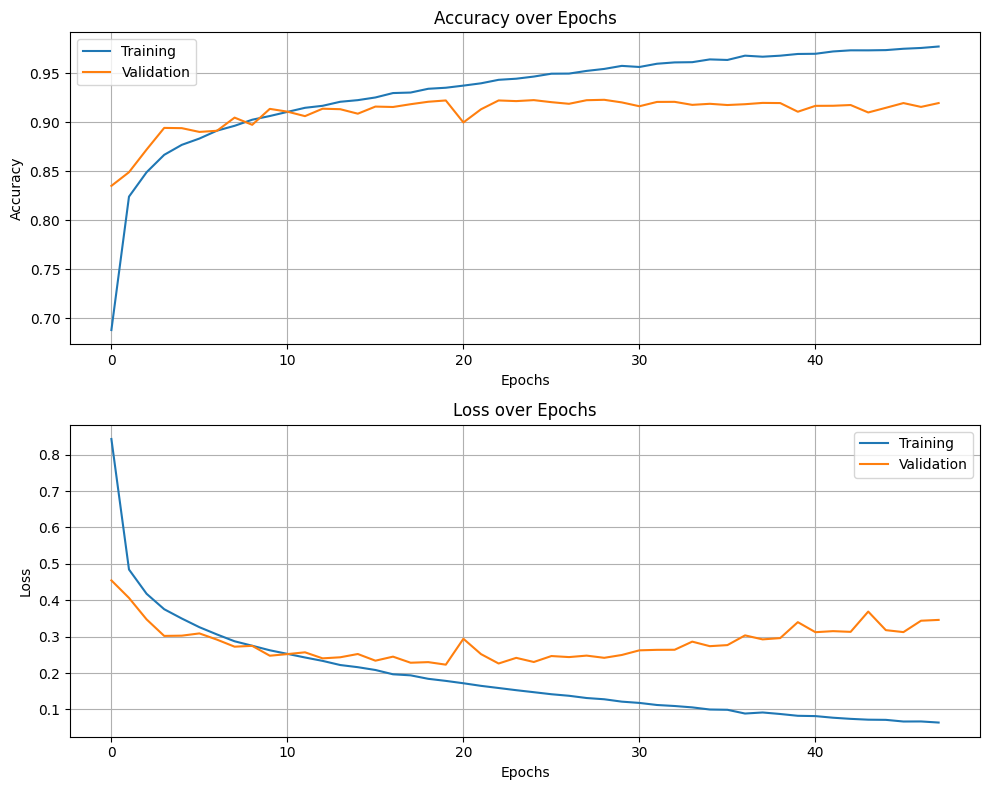

Predicted Classes [0 1 2 3 4 5 6 7 8 9]
Truth Classes [0 1 2 3 4 5 6 7 8 9]
              precision    recall  f1-score   support

     T-Shirt       0.82      0.89      0.85      1000
     Trouser       1.00      0.97      0.98      1000
    Pullover       0.88      0.87      0.87      1000
       Dress       0.89      0.94      0.91      1000
        Coat       0.88      0.84      0.86      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.77      0.72      0.74      1000
     Sneaker       0.96      0.97      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle Boot       0.97      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [36]:
make_plot_history(history4)
make_model_analysis(model4, test_images_tensor, test_labels_tensor,device=device)

Text(0, 0.5, 'Validation Accuracy')

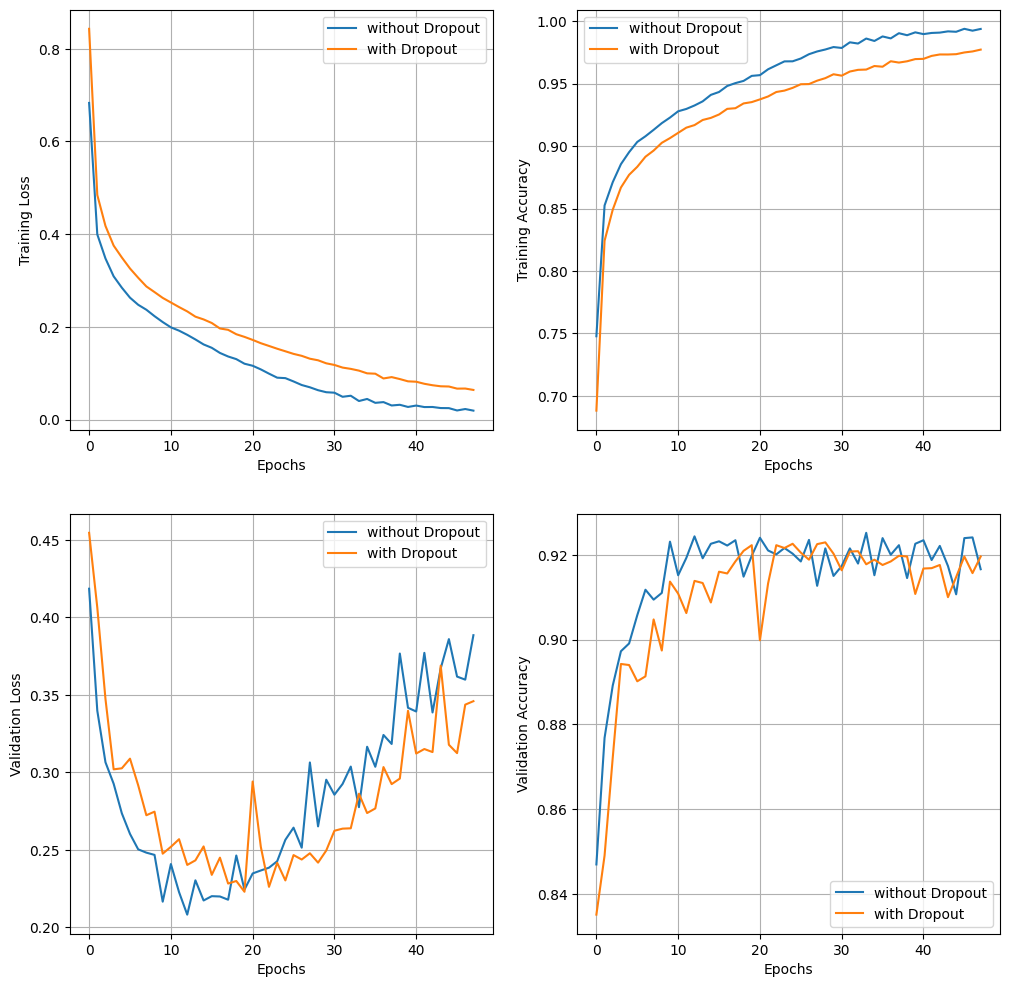

In [37]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.plot(history3['train_loss'],label='without Dropout')
plt.plot(history4['train_loss'],label='with Dropout')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.subplot(2,2,2)
plt.plot(history3['train_acc'],label='without Dropout')
plt.plot(history4['train_acc'],label='with Dropout')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.subplot(2,2,3)
plt.plot(history3['val_loss'],label='without Dropout')
plt.plot(history4['val_loss'],label='with Dropout')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.subplot(2,2,4)
plt.plot(history3['val_acc'],label='without Dropout')
plt.plot(history4['val_acc'],label='with Dropout')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

**Question 9**  
Compare all trained model in a plot of number of parameters and performance on test dataset.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.1 79658
0.7173 79658
0.9226 79658
0.9149 217434
0.912 217434


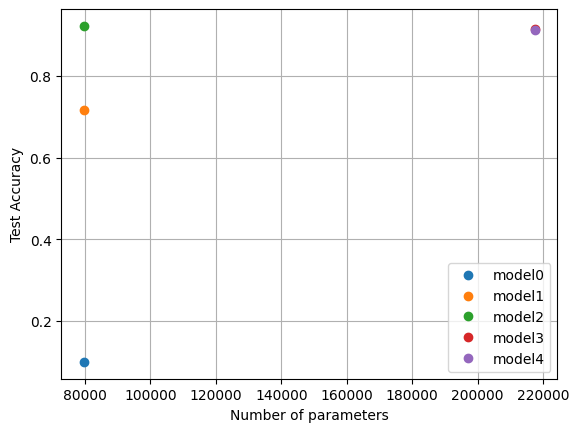

In [38]:
def make_model_analysis_parameters(model, x_test, y_test,device):
    """
    Evaluate a trained PyTorch model and generate a classification report.

    Args:
        model (nn.Module): Trained PyTorch model.
        x_test (torch.Tensor): Test images tensor (shape: [N, 1, 28, 28]).
        y_test (torch.Tensor): True labels tensor.
        device (torch.device): Device where the model is located (CPU/GPU).
    """
    # Set model to evaluation mode
    model.eval()

    # Move test data to the same device as the model
    x_test = x_test.to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(x_test)
        _, y_pred = torch.max(outputs, dim=1)  # Get predicted class indices

    # Move predictions and labels to CPU for numpy conversion
    y_pred = y_pred.cpu().numpy()
    y_test = y_test.numpy()

    # Class names for Fashion MNIST
    target_names = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

    # Generate and print classification report
    CR=classification_report(y_test, y_pred, target_names=target_names,output_dict=True)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(CR['accuracy'],total_params)
    return CR['accuracy'],total_params



list_of_models=[model0,model1,model2,model3,model4]
res=[]
for model in list_of_models:
  acc,total_par=make_model_analysis_parameters(model, test_images_tensor, test_labels_tensor,device=device)
  res.append([acc,total_par])

for i in range(len(list_of_models)):
  plt.plot(res[i][1],res[i][0],'o',label='model'+str(i))
plt.xlabel('Number of parameters')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid()
plt.show()


In [39]:
print(model2)

FashionMNISTModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (globalpool): AdaptiveAvgPool2d(output_size=1)
  (dense): Linear(in_features=96, out_features=10, bias=True)
)


As you can see the dropout layer could prevent overfitting a little bit and increased the training loss.

**Question 10**  

Retrain the model using "batch normalization layer" instead of "layer normalization".

a. Does this model get better results for this problem?

b. Explain why the model with Batch Normalization has fewer parameters than the one using Layer Normalization.

The biases = False in Batch Normalization, too.

In [41]:
model5=FashionMNISTModelwithBatchNormalization((1,28,28),10)
summary(model5, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FashionMNISTModelwithBatchNormalization  [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 28, 28]           144
├─BatchNorm2d: 1-2                       [1, 16, 28, 28]           32
├─Conv2d: 1-3                            [1, 32, 28, 28]           4,608
├─BatchNorm2d: 1-4                       [1, 32, 28, 28]           64
├─MaxPool2d: 1-5                         [1, 32, 14, 14]           --
├─Conv2d: 1-6                            [1, 64, 14, 14]           18,432
├─BatchNorm2d: 1-7                       [1, 64, 14, 14]           128
├─Conv2d: 1-8                            [1, 96, 14, 14]           55,296
├─BatchNorm2d: 1-9                       [1, 96, 14, 14]           192
├─AdaptiveAvgPool2d: 1-10                [1, 96, 1, 1]             --
├─Linear: 1-11                           [1, 10]                   970
Total params: 79,866
Trainable params: 79,866
Non-trainable params: 0


In [42]:
optimizer, criterion = configure_model(model5,optimizer_name="adam",learning_rate=0.001,loss_type="cross_entropy")
history5 = train_model(
    model=model5,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=NEPOCHS,
    device=device,
)

Validation loss improved to 0.5009. Model saved.
Epoch 1/48: Train Loss: 0.6137, Train Acc: 0.7973, Val Loss: 0.5009, Val Acc: 0.8147
Validation loss improved to 0.4649. Model saved.
Epoch 2/48: Train Loss: 0.3658, Train Acc: 0.8693, Val Loss: 0.4649, Val Acc: 0.8337
Validation loss improved to 0.4347. Model saved.
Epoch 3/48: Train Loss: 0.3131, Train Acc: 0.8891, Val Loss: 0.4347, Val Acc: 0.8572
Validation loss improved to 0.2854. Model saved.
Epoch 4/48: Train Loss: 0.2858, Train Acc: 0.8980, Val Loss: 0.2854, Val Acc: 0.9011
Validation loss improved to 0.2720. Model saved.
Epoch 5/48: Train Loss: 0.2627, Train Acc: 0.9055, Val Loss: 0.2720, Val Acc: 0.9083
Validation loss improved to 0.2678. Model saved.
Epoch 6/48: Train Loss: 0.2474, Train Acc: 0.9110, Val Loss: 0.2678, Val Acc: 0.9033
Epoch 7/48: Train Loss: 0.2351, Train Acc: 0.9148, Val Loss: 0.3045, Val Acc: 0.8913
Validation loss improved to 0.2438. Model saved.
Epoch 8/48: Train Loss: 0.2238, Train Acc: 0.9187, Val Loss: 0

Text(0, 0.5, 'Validation Accuracy')

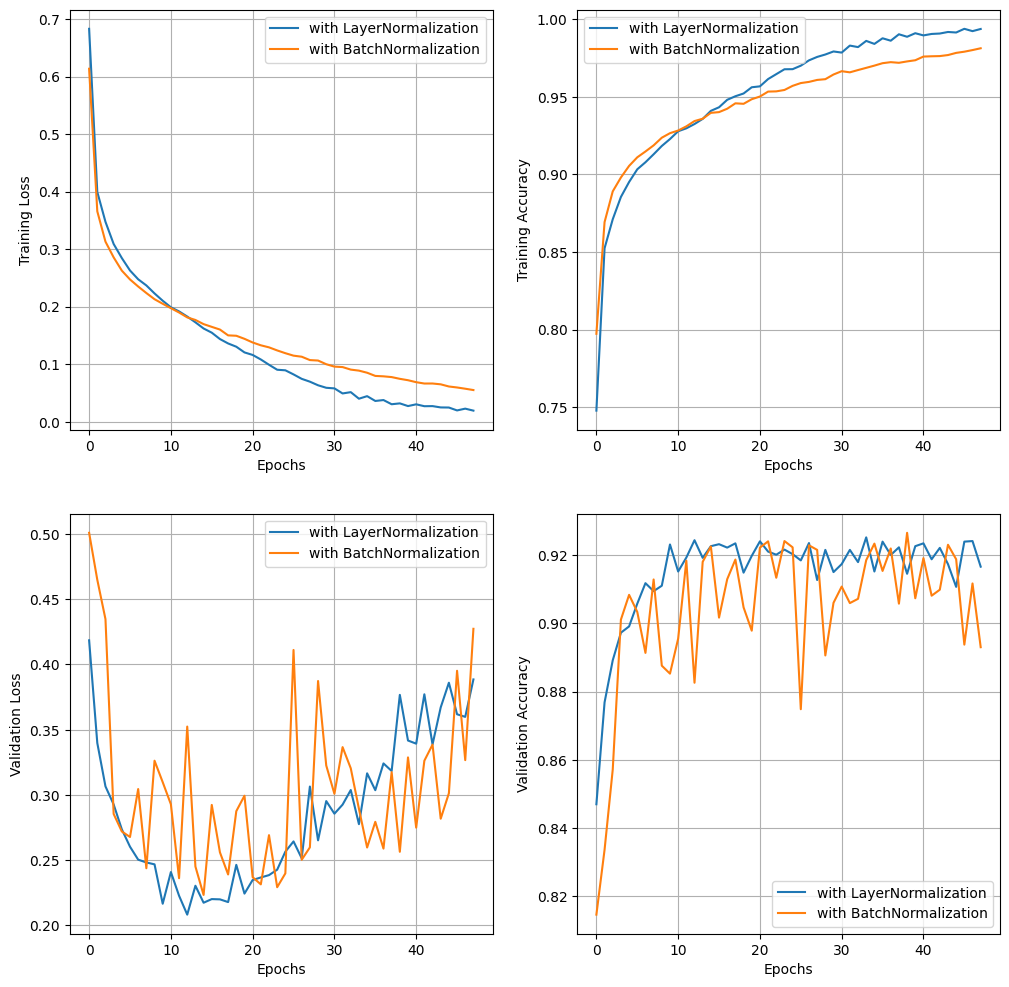

In [43]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.plot(history3['train_loss'],label='with LayerNormalization')
plt.plot(history5['train_loss'],label='with BatchNormalization')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.subplot(2,2,2)
plt.plot(history3['train_acc'],label='with LayerNormalization')
plt.plot(history5['train_acc'],label='with BatchNormalization')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.subplot(2,2,3)
plt.plot(history3['val_loss'],label='with LayerNormalization')
plt.plot(history5['val_loss'],label='with BatchNormalization')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.subplot(2,2,4)
plt.plot(history3['val_acc'],label='with LayerNormalization')
plt.plot(history5['val_acc'],label='with BatchNormalization')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

**Answer 11**

a) Using Batch Normalization did not produce better results on the training set. As we can see, the training loss with Layer Normalization is lower, and the training accuracy is higher. However, on the validation set, the validation loss is slightly lower for Batch Normalization and the validation accuracy is slightly higher for Layer Normalization.
Overall, overfitting is more noticeable in the Layer Normalization model than in the Batch Normalization model.

b) Bachnorm2d has two trainable parameters per channel which are scale and shift. So the number of parameters are 2*c. But in layerNorm we normalize over [c,h,w]. So it learns scale and shift parameters for each element, giving 2 *c *h *w parameters. That's why Batch Normalization requires much fewer parameters than Layer Normalization.

**Question 11**

Which of these techniques can be applied to reduce model overfitting?
1.   Layer Normalization
2. Changing SGD by ADAM as optimizer
3. Dropout
4. Data augmentation

**Answer 11**

Dropout and data augmentation can reduce model overfitting.

Layer Normalization helps stabilize and speed up training, but it does not directly reduce overfitting.

Adam improves convergence speed but does not help reduce overfitting. In fact, because it converges quickly to the training data, it can sometimes increase overfitting.

Dropout randomly disables some neurons during training, forcing the model to rely on multiple pathways. It acts as a regularization technique, which helps reduce overfitting.

In data augmentation, we artificially increase the amount and diversity of training data. This helps the model generalize better and thus reduces overfitting.

**Question 12**

Which of these statements about dropout is correct?

1. Dropout results in sparsity within the trained weights.
2. During testing, dropout is implemented using the inverted keep probability.
3. Increasing the keep probability of a layer enhances the regularization of its weights.
4. None of the above.

**Answer 12**

4 is correct.

The first one is wrong because dropout randomly drops neurons during training and not weights.
It does not make the learned weights sparse. It only affects which neurons are active during training.

The second one is wrong. During training phase, dropout randomly turns off some neurons. If we drop neurons without adjusting anything, then during training the layer's output have smaller magnitude. Then at test time all neurons are active, so the output magnitude would be much larger and make predictions inconsistent. So in pytorch and tensorflow we use inverted dropout which in the training phase each active neuron's output is scaled up by 1/p. This ensures that the expected output of the layer stays the same even though some neurons are dropped. But during testing phase, dropout is disabled and all neurons are active. So no scaling is needed, because the training-time scaling already compensated for it.

The third one is wrong because when keep probability increases, the number of inactive neurons decreases. So it results to weaker regularization and vice versa.

**Question 13**

Given the following activation function  𝙻𝚎𝚊𝚔𝚢𝚁𝚎𝙻𝚄(𝑥)=𝑥 𝚒𝚏 𝑥>0,𝛼𝑥 𝚒𝚏 𝑥≤0 .

1. Derive the first derivative with respect to  𝑥 .

2. What is the behavior of the derivative when  𝛼  goes to zero?

3. How does this can affect backpropagation?

1. Leaky ReLU:


$$
f(x) =
\begin{cases}
x, & \text{if } x > 0 \\
\alpha x, & \text{if } x \le 0
\end{cases}
$$

where $ \alpha $ is a small positive constant.


Derivative with respect to $x$:

$$
f'(x) =
\begin{cases}
1, & \text{if } x > 0 \\
\alpha, & \text{if } x \le 0
\end{cases}
$$

So, the gradient is 1 on the positive side and $\alpha$ on the negative side.

---

2. Behavior when $\alpha \to 0$

When $\alpha \to 0$:

$$
f'(x) =
\begin{cases}
1, & x > 0 \\
0, & x \le 0
\end{cases}
$$

This means the Leaky ReLU becomes the ReLU function.

---

3. Effect on Backpropagation

For Leaky ReLU, even when $ x \le 0 $, the gradient is small $ \alpha$ and not zero.
This allows some gradient flow through negative inputs, helping the network continue learning.

When $\alpha \to 0$ and leaky ReLU becomes ReLU, the derivative becomes 0 for all negative inputs and neurons with negative inputs stop updating their weights which is the dying ReLU problem.

**Question 14**

Given these two activation functions $\texttt{sigmoid}=\frac{1}{1+\exp(-x)}$ and $\texttt{tanh}(x) = \frac{\exp(x)−\exp(−x)}{\exp(x)+\exp(−x)}$

1. Show for what value of $a,b$, $ a\texttt{sigmoid}(2x) - b = \texttt{tanh}(x)$



We have

$$
\text{sigmoid}(x) = \frac{1}{1 + e^{-x}}, \qquad
\text{tanh}(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
$$

We want to find $a$ and $b$ in a way that satisfys:

$$
a\texttt{sigmoid}(2x) - b = \texttt{tanh}(x)
$$

We can write:

$$
\text{sigmoid}(2x) = \frac{1}{1 + e^{-2x}}
$$

Multiply by $e^{x}$:

$$
\text{tanh}(x)
= \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
= \frac{e^{2x} - 1}{e^{2x} + 1}
$$

So we should have $e^{2x}$ in the $\text{sigmoid}(2x)$ function

$$
\text{sigmoid}(2x)
= \frac{1}{1 + e^{-2x}}
= \frac{e^{2x}}{e^{2x} + 1}
$$

We need:

$$
a \cdot \frac{e^{2x}}{e^{2x} + 1} - b = \frac{e^{2x} - 1}{e^{2x} + 1}
$$

We multiply both sides by $ e^{2x} + 1 $:

$$
a e^{2x} - b(e^{2x} + 1) = e^{2x} - 1
$$

Simplify:

$$
a e^{2x} - b e^{2x} - b = e^{2x} - 1
$$

$$
e^{2x}(a - b) - b = e^{2x} - 1
$$

We compare both sides term-by-term:

$$
\begin{cases}
a - b = 1 \\
-b = -1
\end{cases}
$$

From the second equation: $ b = 1 $.  
And $ a - 1 = 1 \Rightarrow a = 2 $.

**Question 15**

Given the Swish activation function with a trainable parameter $\beta$:

$\texttt{swish}(x,\beta)=x \texttt{sigmoid}(\beta x) =\frac{x}{1+ \exp⁡(−\beta x)}$
and the ReLU activation function:
$\texttt{ReLU}(x)=\max⁡(x,0)$


1. Show that $\lim_{\beta \to \infty} \texttt{swish}(x, \beta) = ReLU(x)$

We have:

$$
\text{swish}(x, \beta) = x \, \text{sigmoid}(\beta x)
= \frac{x}{1 + e^{-\beta x}}
$$

and:

$$
\text{ReLU}(x) = \max(x, 0)
$$

We want to show:

$$
\lim_{\beta \to \infty} \text{swish}(x, \beta) = \text{ReLU}(x)
$$

We know that:

$$
\text{sigmoid}(z) = \frac{1}{1 + e^{-z}}
$$

$$
\lim_{z \to +\infty} \text{sigmoid}(z) = 1, \quad
\lim_{z \to -\infty} \text{sigmoid}(z) = 0
$$

Now when $\beta \to \infty$:

If $x > 0$, then $\beta x \to +\infty \Rightarrow \text{sigmoid}(\beta x) \to 1 $

If $x < 0$, then $\beta x \to -\infty \Rightarrow \text{sigmoid}(\beta x) \to 0$

If $x = 0$, then $ \text{sigmoid}(0) = \frac{1}{2} $

Then:

$$
\text{swish}(x, \beta) = x \, \text{sigmoid}(\beta x)
$$

So:

$$
\lim_{\beta \to \infty} \text{swish}(x, \beta) =
\begin{cases}
x \cdot 1 = x, & \text{if } x > 0 \\
x \cdot 0 = 0, & \text{if } x < 0 \\
0 \cdot \frac{1}{2} = 0, & \text{if } x = 0
\end{cases}
$$

So:

$$
\lim_{\beta \to \infty} \text{swish}(x, \beta) =
\begin{cases}
x, & x > 0 \\
0, & x \le 0
\end{cases}
= \max(x, 0)
$$

In result:

$$
\lim_{\beta \to \infty} \text{swish}(x, \beta) = \text{ReLU}(x)
$$


**Question 16** (5 points)

Implement the activation function Dynamic Tanh of the paper

Zhu, J., Chen, X., He, K., LeCun, Y., & Liu, Z. (2025). Transformers without normalization. In Proceedings of the Computer Vision and Pattern Recognition Conference (pp. 14901-14911).

https://arxiv.org/pdf/2503.10622

in a class call FashionMNISTModelwithDynamicTanh.

Compare the performance and number of parameter of this model with the others used before.

Dynamic Tanh is a new type of activation function that works like the normal tanh, but it adapts itself automatically during training.

In normal activations like ReLU or tanh, the shape of the function is fixed and it doesn't change as the model learns. But in Dynamic Tanh, the function has an internal parameter that changes based on the input distribution, which means it can stretch or squeeze its curve depending on what the network needs.

This helps the model keep its activations in a good range (not too large or too small) without needing normalization layers like BatchNorm or LayerNorm.

In [46]:
class DynamicTanh2d(nn.Module):
    def __init__(self, num_channels: int, alpha_init: float = 1.0):
        super(DynamicTanh2d, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha_init, dtype=torch.float32))
        self.gamma = nn.Parameter(torch.ones(num_channels, 1, 1, dtype=torch.float32))
        self.beta  = nn.Parameter(torch.zeros(num_channels, 1, 1, dtype=torch.float32))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.gamma * torch.tanh(self.alpha * x) + self.beta

In [56]:
class FashionMNISTModelwithDynamicTanh(nn.Module):
  def __init__(self, input_shape, num_classes):
        """
        Replace normalization+ReLU with Dynamic Tanh.
        Convolutional layers use bias=False.
        """
        super(FashionMNISTModelwithDynamicTanh, self).__init__()
        C, H, W = input_shape

        self.conv1 = nn.Conv2d(C, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.dyt1  = DynamicTanh2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.dyt2  = DynamicTanh2d(32)

        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.dyt3  = DynamicTanh2d(64)

        self.conv4 = nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1, bias=False)
        self.dyt4  = DynamicTanh2d(96)

        self.globalpool = nn.AdaptiveAvgPool2d(1)
        self.dense = nn.Linear(96, num_classes)

  def forward(self, x):

        x = self.conv1(x)
        x = self.dyt1(x)

        x = self.conv2(x)
        x = self.dyt2(x)

        # MaxPool
        x = self.pool(x)

        x = self.conv3(x)
        x = self.dyt3(x)

        x = self.conv4(x)
        x = self.dyt4(x)

        # Global Average Pooling + Flatten + Dense
        x = self.globalpool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dense(x)

        return x

In [57]:
model6=FashionMNISTModelwithDynamicTanh((1,28,28),10)
summary(model6, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FashionMNISTModelwithDynamicTanh         [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 28, 28]           144
├─DynamicTanh2d: 1-2                     [1, 16, 28, 28]           33
├─Conv2d: 1-3                            [1, 32, 28, 28]           4,608
├─DynamicTanh2d: 1-4                     [1, 32, 28, 28]           65
├─MaxPool2d: 1-5                         [1, 32, 14, 14]           --
├─Conv2d: 1-6                            [1, 64, 14, 14]           18,432
├─DynamicTanh2d: 1-7                     [1, 64, 14, 14]           129
├─Conv2d: 1-8                            [1, 96, 14, 14]           55,296
├─DynamicTanh2d: 1-9                     [1, 96, 14, 14]           193
├─AdaptiveAvgPool2d: 1-10                [1, 96, 1, 1]             --
├─Linear: 1-11                           [1, 10]                   970
Total params: 79,870
Trainable params: 79,870
Non-trainable params: 0


In [58]:
optimizer, criterion = configure_model(model6,optimizer_name="adam",learning_rate=0.001,loss_type="cross_entropy")
history6 = train_model(
    model=model6,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=NEPOCHS,
    device=device,
)

Validation loss improved to 0.5077. Model saved.
Epoch 1/48: Train Loss: 0.8186, Train Acc: 0.7019, Val Loss: 0.5077, Val Acc: 0.8219
Validation loss improved to 0.3866. Model saved.
Epoch 2/48: Train Loss: 0.4575, Train Acc: 0.8346, Val Loss: 0.3866, Val Acc: 0.8668
Validation loss improved to 0.3378. Model saved.
Epoch 3/48: Train Loss: 0.3773, Train Acc: 0.8644, Val Loss: 0.3378, Val Acc: 0.8828
Validation loss improved to 0.3035. Model saved.
Epoch 4/48: Train Loss: 0.3356, Train Acc: 0.8792, Val Loss: 0.3035, Val Acc: 0.8930
Validation loss improved to 0.2938. Model saved.
Epoch 5/48: Train Loss: 0.3115, Train Acc: 0.8885, Val Loss: 0.2938, Val Acc: 0.8935
Validation loss improved to 0.2872. Model saved.
Epoch 6/48: Train Loss: 0.2970, Train Acc: 0.8941, Val Loss: 0.2872, Val Acc: 0.8997
Validation loss improved to 0.2706. Model saved.
Epoch 7/48: Train Loss: 0.2810, Train Acc: 0.9000, Val Loss: 0.2706, Val Acc: 0.9053
Epoch 8/48: Train Loss: 0.2740, Train Acc: 0.9031, Val Loss: 0

Text(0, 0.5, 'Validation Accuracy')

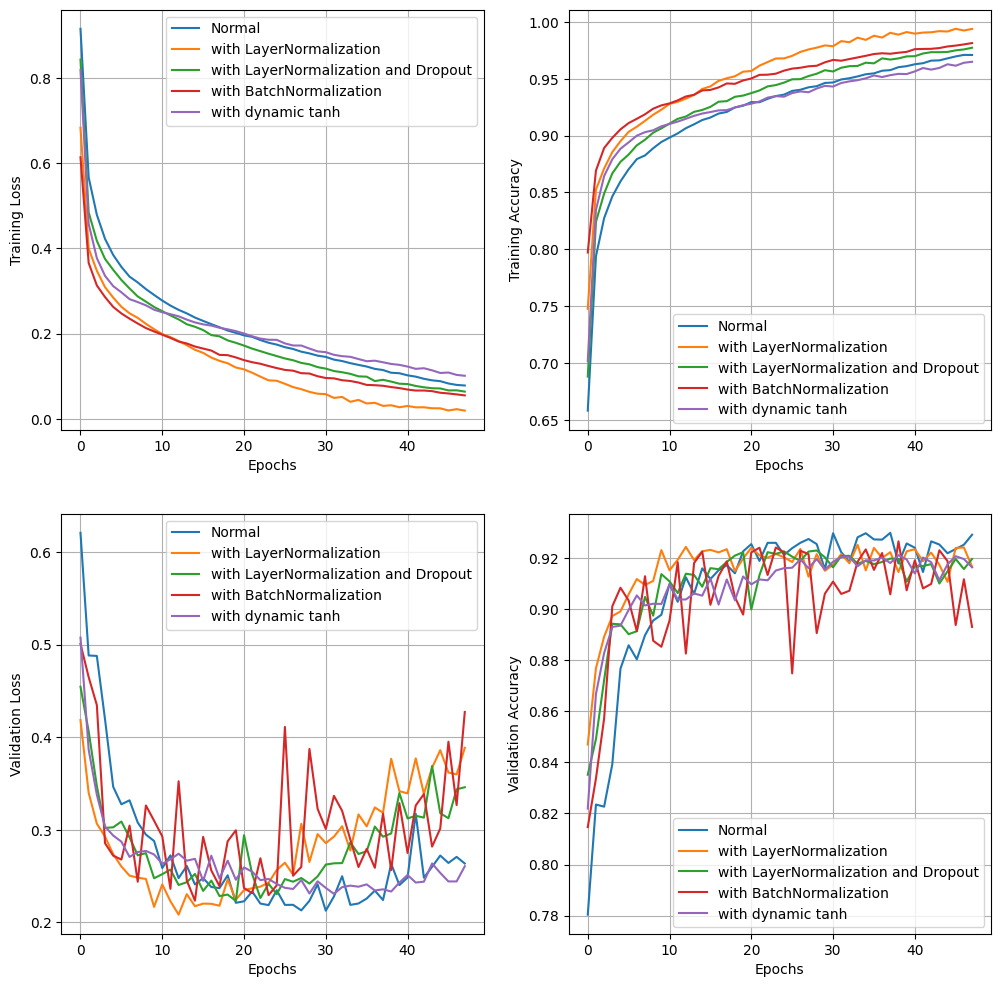

In [59]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.plot(history2['train_loss'],label='Normal')
plt.plot(history3['train_loss'],label='with LayerNormalization')
plt.plot(history4['train_loss'],label='with LayerNormalization and Dropout')
plt.plot(history5['train_loss'],label='with BatchNormalization')
plt.plot(history6['train_loss'],label='with dynamic tanh')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.subplot(2,2,2)
plt.plot(history2['train_acc'],label='Normal')
plt.plot(history3['train_acc'],label='with LayerNormalization')
plt.plot(history4['train_acc'],label='with LayerNormalization and Dropout')
plt.plot(history5['train_acc'],label='with BatchNormalization')
plt.plot(history6['train_acc'],label='with dynamic tanh')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.subplot(2,2,3)
plt.plot(history2['val_loss'],label='Normal')
plt.plot(history3['val_loss'],label='with LayerNormalization')
plt.plot(history4['val_loss'],label='with LayerNormalization and Dropout')
plt.plot(history5['val_loss'],label='with BatchNormalization')
plt.plot(history6['val_loss'],label='with dynamic tanh')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.subplot(2,2,4)
plt.plot(history2['val_acc'],label='Normal')
plt.plot(history3['val_acc'],label='with LayerNormalization')
plt.plot(history4['val_acc'],label='with LayerNormalization and Dropout')
plt.plot(history5['val_acc'],label='with BatchNormalization')
plt.plot(history6['val_acc'],label='with dynamic tanh')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

0.9226 79658
0.9149 217434
0.912 217434
0.9144 79866
0.9121 79870


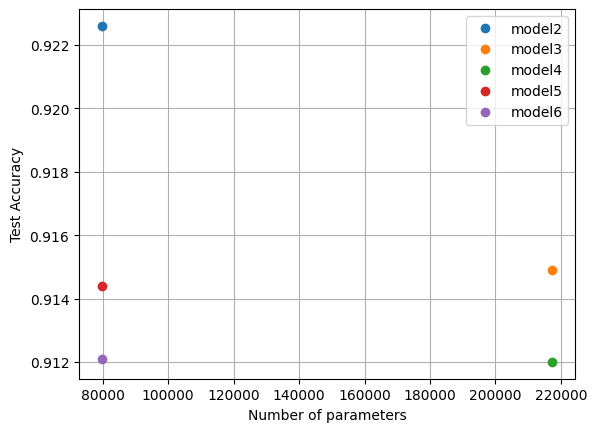

In [55]:
list_of_models=[model2, model3, model4, model5, model6]
res=[]
for model in list_of_models:
  acc,total_par=make_model_analysis_parameters(model, test_images_tensor, test_labels_tensor,device=device)
  res.append([acc,total_par])

for i in range(len(list_of_models)):
  plt.plot(res[i][1],res[i][0],'o',label='model'+str(i+2))
plt.xlabel('Number of parameters')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid()
plt.show()

As shown in the plots above, the Normal CNN converges smoothly but more slowly at the beginning. Both Layer Normalization and Batch Normalization accelerated convergence and their losses dropped faster showing improved optimization stability. The Dropout model trained more slowly due to random neuron deactivation while the Dynamic Tanh model achieved a stable and consistent training loss.

During the validation phase, both BatchNorm and LayerNorm models showed an increase in validation loss after several epochs showing small overfitting. The Dynamic Tanh model maintained a more stable validation loss but did not surpass the baseline model's accuracy.

The highest test accuracy belongs to the baseline Normal CNN model, which also has the fewest parameters. In contrast, Layer Normalization results in the largest number of parameters due to its per-element scaling and shifting.

It is important to note that these results may vary slightly due to randomness, and the performance differences among models are relatively small.

Overall, the Normal CNN achieved the best accuracy, while the Dynamic Tanh model showed performance comparable to the Batch Normalization model which offers a normalization-free alternative with similar behavior.